# Discrete Cosine Transform
A notebook on algorithms to compute the discrete cosine transform by Matt Beveridge.
## Introduction
The Discrete Cosine Transform is a variant of the Fourier Transform. For the one-dimensional case, the formal definition is the following where $x_k$ is the input and $y_k$ is the transformed version:
\begin{align}
    y_n &= c_n \sum_{k=0}^{N-1} x_k \cos \left(\frac{n\pi}{2N} (2k+1)\right)
\end{align}
Where $c_0 = 1/\sqrt{N}$ and $c_n = \sqrt{2/N}$ for $n=1,2,\dots, N-1$. 


For the two-dimensional case it is:
\begin{align}
    y_{n_1,n_2} &= c_{n_1} \sum_{k_1=0}^{N_1-1} \left[ c_{n_2} \sum_{k_2=0}^{N_2-1} \cos \left(\frac{n_2\pi}{2N_2} (2k_2+1)\right) \right] \cos \left(\frac{n_1\pi}{2N_1} (2k_1+1)\right) \\
    &= c_{n_1} c_{n_2} \sum_{k_1=0}^{N_1-1} \sum_{k_2=0}^{N_2-1} \cos \left(\frac{n_2\pi}{2N_2} (2k_2+1)\right) \cos \left(\frac{n_1\pi}{2N_1} (2k_1+1)\right)
\end{align}

Naively following these formulas, it takes $O(N^2)$ operations to compute this transform.

## Naive Approach
In the naive approach, we simply follow the above equations.
### One-Dimensional DCT
The one-dimensional DCT transforms one-dimensional vectors into the frequency domain.

In [144]:
function naive_DCT_1D(x)
    dims = size(x)
    @assert (ndims(x)==1 || dims[1]==1 || dims[2] == 1) "vector must be one-dimensional"
    
    N = length(x)
    X = Array{Float64}(undef, N)
    x = reshape(x, maximum(dims), 1)
    
    for k in 0:N-1
        δ = if(k==0) sqrt(0.5) else 1. end 
        
        sum = 0.0
        for n in 0:N-1
            sum += x[n+1] * cos((π/N)*(n+0.5)*k)
        end
        
        X[k+1] = sqrt(2. / N) * δ * sum
    end
    X = reshape(X, dims)
    return X
end

naive_DCT_1D (generic function with 1 method)

### Two-Dimensional DCT
The two-dimensional DCT transforms two-dimensional vectors into the frequency domain.

In [145]:
function naive_DCT_2D(x)
    @assert (length(size(x))==2) "vector must be two-dimensional"
    N1, N2 = size(x)
    X = Array{Float64}(undef, N1, N2)
    
    # inner loop
    function innerloop(k1, k2)    
        sum = 0.0
        for n1 in 0:N1-1
            for n2 in 0:N2-1
                sum += x[n1+1, n2+1] * cos(π/N1 * (n1+1/2) * k1) * cos(π/N2 * (n2+1/2) * k2)
            end
        end
        
        δ1 = if(k1==0) sqrt(0.5) else 1. end 
        δ2 = if(k2==0) sqrt(0.5) else 1. end
        C1 = sqrt(2. / N1)
        C2 = sqrt(2. / N2)
        return C1*C2*δ1*δ2 *  sum
    end
    
    # outer loop
    for k1 in 0:N1-1
        for k2 in 0:N2-1
            X[k1+1, k2+1] = innerloop(k1, k2)
        end
    end
                
    return X    
end

naive_DCT_2D (generic function with 1 method)

### General DCT (1D or 2D)
Of course, any one-dimensional vector can be rewritten as a two-dimensional vector. This means the two-dimensional DCT can be used for either, although this would be less efficient. For the general form, we decide $not$ to do this and instead adjust our course of action based on the number of dimensions. Either way, using the general form is slower than using the form specific to your input's dimensions.

In [146]:
function naive_DCT(x)
    @assert (ndims(x)<=2) "vector cannot have more than two dimensions"
    dims = size(x)    
    if length(dims) == 1 || dims[1] == 1 || dims[2] == 1
        return naive_DCT_1D(x)
    else 
        return naive_DCT_2D(x)
    end
end

naive_DCT (generic function with 1 method)

## Smart Approach
As previously noted, the naive algorithms run in $O(N^2)$. However, the state of the art run in $O(N\log N)$. As you'll see below, the difference quickly becomes clear. 

In [161]:
using FFTW

A = rand(5,5)
@time naive_DCT(A) #my naive algorithm
@time dct(A) #the good stuff (leading algorithm)

  0.000145 seconds (6 allocations: 480 bytes)
  0.000520 seconds (105 allocations: 6.109 KiB)


5×5 Array{Float64,2}:
  2.33017     0.123716  -0.269805    0.200765    0.255385 
 -0.250742   -0.164751  -0.481428    0.0740704   0.321384 
 -0.667611    0.182761   0.153201    0.256299    0.0444179
 -0.0432968  -0.211119  -0.0917634  -0.34907    -0.20388  
  0.171248   -0.308896  -0.0633409  -0.43285     0.167039 

For small $N$, the naive algorithm is actually faster as there are less constant time operations. This advantage disappears for larger $N$.

In [162]:
A = rand(100,100)
@time naive_DCT(A) #my naive algorithm
@time dct(A) #the good stuff (leading algorithm)

  5.183291 seconds (7 allocations: 78.391 KiB)
  0.000868 seconds (107 allocations: 87.047 KiB)


100×100 Array{Float64,2}:
 49.9091       0.344111    0.443109    …  -0.155577     0.258617   -0.309064 
 -0.593676     0.348605    0.599359        0.376356    -0.0648678  -0.365455 
  0.438814    -0.0405729  -0.195075       -0.0105401    0.102823   -0.212902 
  0.151063    -0.282751    0.297914        0.31494      0.342832   -0.308807 
  0.0319965    0.421471    0.33088        -0.134173    -0.153701   -0.142023 
  0.0330111   -0.129306   -0.299687    …  -0.0634229    0.220155    0.375877 
  0.468238     0.0281991   0.170074       -0.00775143   0.368753   -0.173392 
  0.288913     0.262707   -0.11687         0.155728    -0.173084   -0.0584141
  0.0866491    0.310401   -0.0145558       0.387326     0.205745   -0.246147 
 -0.0804124    0.343005   -0.254185        0.145526     0.0459231   0.466345 
 -0.349644    -0.0413133  -0.12807     …   0.212368    -0.0208099   0.0351679
  0.38139     -0.388958   -0.389312        0.172512    -0.396583    0.25687  
 -0.471605    -0.145443   -0.084665   

There are several approaches that are used to improve upon this. Here, we will look at the Fast Cosine Transform (FCT).

### One-Dimensional Fast Cosine Transform 

The Fast Cosine Transform (FCT) recursively decomposes the DCT into its even and odd parts. Recall the equation for the one-dimensional DCT:
\begin{align}
    y_n &= c_n \sum_{k=0}^{N-1} x_k \cos \left(\frac{n\pi}{2N} (2k+1)\right)
\end{align}
We break this down into the following:
\begin{align}
    g_k &= x_k + x_{(N-1-k)} \\
    h_k &= \frac{x_k-x_{(N-1-k)}}{2\cos \left(\frac{n\pi}{2N}(2k+1)\right)} \\
\end{align}
Further, we define:
\begin{align}
    G_n &= \sum_{k=0}^{\frac{N}{2}-1} g_k \cos \left(\frac{n\pi}{2N}(2k+1)\right) \\
    H_n &= \sum_{k=0}^{\frac{N}{2}-1} h_k \cos \left(\frac{n\pi}{2N}(2k+1)\right)
\end{align}
For $n=0,1,\dots,\frac{N}{2}-1$. Thus,
\begin{align}
    y_{2n} &= G_n \\
    y_{(2n+1)} &= H_n + H_{(n+1)}\\
    H_{\frac{N}{2}} &= 0
\end{align}

This set of equations forms a recursion known as Lee's fast DCT algorithm. Inspiration found at https://www.nayuki.io/res/fast-discrete-cosine-transform-algorithms.

In [149]:
function unscaled_fast_DCT_1D(x)
    n = length(x)

    if n == 1
        return copy(x)
    elseif n==0 || n%2!=0
        throw(ArgumentError("input must be size 2^m"))
    else 
        midpoint = n÷2
        γ = x[1 : midpoint]
        δ = x[n : -1 : midpoint+1]
        α = unscaled_fast_DCT_1D(γ+δ)
        β = unscaled_fast_DCT_1D((γ-δ) ./ (2* cos.((π/n)*collect(0.5:midpoint-0.5))))
        
        X = zero(x)        
        X[1 : 2 : n] = α
        X[2 : 2 : n] = β        
        if length(β) > 1
            X[2 : 2 : n-1] .+= β[2 : length(β)]
        end   

        return X
    end
end

function fast_DCT_1D(x)
    @assert (ndims(x)==1) "input must be one dimensional"
    X = unscaled_fast_DCT_1D(x)
    X .*= sqrt(2/length(X))
    X[1] /= sqrt(2)
    return X
end

fast_DCT_1D (generic function with 1 method)

This algorithm is a significant improvement compared to the naive version. The only downside: the new smart algorithm can only operate on input sizes of $2^m$ for some integer $m$.

In [150]:
A = rand(2^15)
@time naive_DCT(A) #my naive algorithm
@time fast_DCT_1D(A) #my better algorithm
@time dct(A) #the good stuff (leading algorithm)

 26.138800 seconds (62.31 k allocations: 3.566 MiB)
  0.230029 seconds (923.12 k allocations: 80.863 MiB, 10.41% gc time)
  0.008525 seconds (91 allocations: 260.844 KiB)


32768-element Array{Float64,1}:
 90.92365462639059    
  0.15117957902241544 
  0.18935172552610152 
  0.5638185607611432  
 -0.24989417403248826 
  0.05446177879412931 
 -0.3569649235025834  
 -0.020658232737417372
 -0.3880340369707178  
  0.06278977323189183 
 -0.21573817886778307 
  0.18885832683340734 
 -0.06542120952400624 
  ⋮                   
 -0.119005453535457   
  0.10765961918105837 
  0.07997236522914433 
  0.1959345622168107  
 -0.382003836886706   
  0.0640405271966499  
  0.12710147812298936 
 -0.06865250413915101 
 -0.46744514272563686 
 -0.12454296039175546 
  0.029309696558697283
  1.0403026110536149  

### Two-Dimensional Fast Cosine Transform
Of course, the FCT can also be applied to multidimensional inputs.

In [151]:
function fast_DCT_2D(x)
    @assert (ndims(x)==2) "input must be two dimensional"
    N1, N2 = size(x)
    X = copy(x)
    for col in 1:N2
        X[:,col] = fast_DCT_1D(X[:,col]) 
    end
    for row in 1:N1
        X[row,:] = fast_DCT_1D(X[row,:])
    end
    return X
end

fast_DCT_2D (generic function with 1 method)

Again, the input must have dimensions proportional to $(2^n, 2^m)$.

### General FCT (1D or 2D)
As we did for the naive DCT, we will again make a general form for the fast cosine transform.

In [152]:
function fast_DCT(x)
    @assert (ndims(x)<=2) "vector cannot have more than two dimensions"
    dims = size(x)    
    if length(dims) == 1 || dims[1] == 1 || dims[2] == 1
        return fast_DCT_1D(x)
    else 
        return fast_DCT_2D(x)
    end
end

fast_DCT (generic function with 1 method)

In [153]:
A = rand(128, 128)

@time naive_DCT(A) #my naive algorithm
@time fast_DCT(A) #my better algorithm
@time dct(A) #the good stuff (leading algorithm)

 13.791142 seconds (7 allocations: 128.266 KiB)
  0.104544 seconds (435.40 k allocations: 45.365 MiB, 8.42% gc time)
  0.002966 seconds (107 allocations: 137.984 KiB)


128×128 Array{Float64,2}:
 64.3273      -0.168292   -0.264849    …   0.185151     0.043814    0.0728154
  0.196816    -0.0283485   0.0443078       0.137077    -0.466626   -0.469488 
 -0.133787     0.0503269   0.244056        0.432576    -0.254714    0.0555833
  0.0694664   -0.176613   -0.458751       -0.0031233    0.130427   -0.622615 
 -0.0798798   -0.413034   -0.364057       -0.316184     0.0797323  -0.296877 
  0.0419849   -0.458441   -0.57322     …   0.28822      0.107162   -0.304291 
 -0.389341     0.133622    0.173041       -0.471121     0.451494    0.155878 
  0.201987     0.2935     -0.42013        -0.416868     0.19053     0.376185 
  0.0527425   -0.15637    -0.296034        0.250252     0.143154   -0.116965 
  0.0489916   -0.0239951   0.475336       -0.31528     -0.577706    0.424478 
  0.0173663    0.159403    0.174745    …  -0.178395    -0.235697   -0.0175436
  0.261912     0.211654    0.262362       -0.0319476   -0.815647    0.307446 
 -0.222497    -0.429014   -0.0364557  

While the FCT performs better compared to the naive algorithm, it severely lacks in the amount of memory it requires compared to the FFTW version of the DCT. This is one of the reasons the performance is worse, although there are many others. Of course there are many Julia specific optimizations that would heavily improve these algorithms, but the fact holds that the FCT is an incredible improvement upon the naive DCT.

## Cheating
One workaround is using the FFT to compute the DCT since the DCT is simply the real output of the FFT. This way of computing the DCT is asymptotically as fast as the FFT, which is a vast improvement over the naive method. However, this method requires post processing that takes $O(N)$ time.

In [154]:
using FFTW
function FCTviaFFT(x)
    N = length(x)
    _x = copy(x)
    append!(_x, collect(x[N : -1 : 1]))
    ω = fft(_x)[1:N]
    y = zero(x)
    for k=0:N-1
        y[k+1] = 1/sqrt(2N)*(exp(-im*k*π/(2*N))*ω[k+1]).re
    end
    y[1] /= sqrt(2)
    return y
end

FCTviaFFT (generic function with 1 method)

## Performance

In [155]:
using BenchmarkTools

A = rand(2^10) 

display(@benchmark naive_DCT(A))
display(@benchmark fast_DCT(A))
display(@benchmark FCTviaFFT(A))
display(@benchmark dct(A))

BenchmarkTools.Trial: 
  memory estimate:  8.22 KiB
  allocs estimate:  3
  --------------
  minimum time:     21.372 ms (0.00% GC)
  median time:      23.910 ms (0.00% GC)
  mean time:        24.927 ms (0.00% GC)
  maximum time:     41.838 ms (0.00% GC)
  --------------
  samples:          201
  evals/sample:     1

BenchmarkTools.Trial: 
  memory estimate:  1.50 MiB
  allocs estimate:  12276
  --------------
  minimum time:     810.500 μs (0.00% GC)
  median time:      933.201 μs (0.00% GC)
  mean time:        1.275 ms (18.26% GC)
  maximum time:     13.598 ms (70.19% GC)
  --------------
  samples:          3890
  evals/sample:     1

BenchmarkTools.Trial: 
  memory estimate:  131.94 KiB
  allocs estimate:  62
  --------------
  minimum time:     209.499 μs (0.00% GC)
  median time:      222.100 μs (0.00% GC)
  mean time:        259.467 μs (5.64% GC)
  maximum time:     6.510 ms (86.60% GC)
  --------------
  samples:          10000
  evals/sample:     1

BenchmarkTools.Trial: 
  memory estimate:  12.73 KiB
  allocs estimate:  86
  --------------
  minimum time:     83.300 μs (0.00% GC)
  median time:      91.200 μs (0.00% GC)
  mean time:        105.587 μs (2.45% GC)
  maximum time:     16.750 ms (40.74% GC)
  --------------
  samples:          10000
  evals/sample:     1

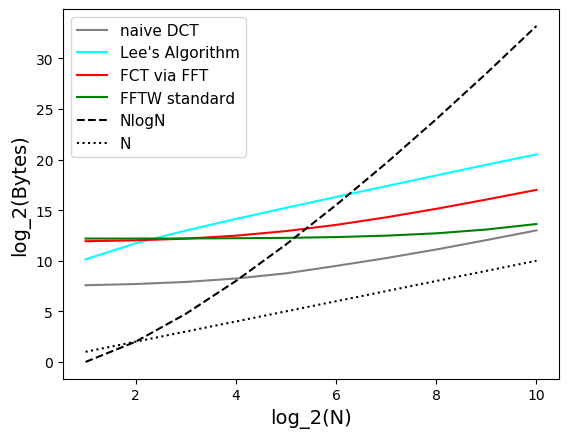

PyObject <matplotlib.legend.Legend object at 0x0000000048CAF898>

In [156]:
using PyPlot

#bytes
naive = [192, 208, 240, 304, 432, 720, 1230, 2220, 4220, 8220]
fast = [1130, 3390, 8130, 18000, 38560, 81340, 170530, 355730, 738970, 1500000]
via = [3910, 4160, 4660, 5720, 7830, 11980, 20090, 36030, 68030, 131940]
fftw = [4690, 4700, 4730, 4800, 4920, 5200, 5730, 6720, 8730, 12730]

N = [2^i for i=1:10]

plot(log2.(N), log2.(naive), label="naive DCT", color="gray")
plot(log2.(N), log2.(fast), label="Lee's Algorithm", color="cyan")
plot(log2.(N), log2.(via), label="FCT via FFT", color="red")
plot(log2.(N), log2.(fftw), label="FFTW standard", color="green")
# plot(log2.(N), [i^2 for i in log2.(N)], label="N^2", linestyle="dashdot", color="black")
plot(log2.(N), [i*log2(i) for i in log2.(N)], label="NlogN", linestyle="dashed", color="black")
plot(log2.(N), [i for i in log2.(N)], label="N", linestyle="dotted", color="black")
xlabel("log_2(N)", size=14)
ylabel("log_2(Bytes)", size=14)
legend(fontsize=11)


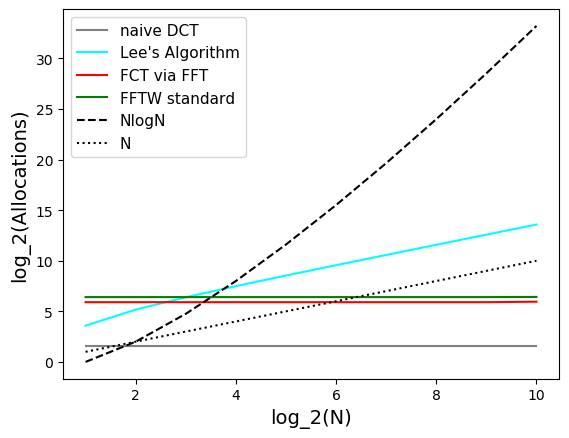

PyObject <matplotlib.legend.Legend object at 0x0000000048D43048>

In [157]:
#allocations
naive = [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
fast = [12, 36, 84, 180, 372, 756, 1524, 3060, 6132, 12276]
via = [60, 60, 60, 60, 60, 60, 60, 60, 60, 62]
fftw = [85, 85, 85, 85, 85, 85, 85, 85, 85, 86]

N = [2^i for i=1:10]

plot(log2.(N), log2.(naive), label="naive DCT", color="gray")
plot(log2.(N), log2.(fast), label="Lee's Algorithm", color="cyan")
plot(log2.(N), log2.(via), label="FCT via FFT", color="red")
plot(log2.(N), log2.(fftw), label="FFTW standard", color="green")
# plot(log2.(N), [i^2 for i in log2.(N)], label="N^2", linestyle="dashdot", color="black")
plot(log2.(N), [i*log2(i) for i in log2.(N)], label="NlogN", linestyle="dashed", color="black")
plot(log2.(N), [i for i in log2.(N)], label="N", linestyle="dotted", color="black")
xlabel("log_2(N)", size=14)
ylabel("log_2(Allocations)", size=14)
legend(fontsize=11)

In [158]:
using GFlops

A = rand(2^5) 

display(@count_ops naive_DCT(A))
display(@count_ops fast_DCT(A))
display(@count_ops FCTviaFFT(A))
display(@count_ops dct(A))

Flop Counter:
 add32: 0
 sub32: 0
 mul32: 0
 div32: 0
 add64: 4056
 sub64: 7359
 mul64: 13021
 div64: 2888
 sqrt32: 0
 sqrt64: 94


Flop Counter:
 add32: 0
 sub32: 0
 mul32: 0
 div32: 0
 add64: 1278
 sub64: 1289
 mul64: 1334
 div64: 783
 sqrt32: 0
 sqrt64: 34


Flop Counter:
 add32: 0
 sub32: 0
 mul32: 0
 div32: 0
 add64: 218
 sub64: 271
 mul64: 802
 div64: 129
 sqrt32: 0
 sqrt64: 33


Flop Counter:
 add32: 0
 sub32: 0
 mul32: 0
 div32: 0
 add64: 0
 sub64: 0
 mul64: 34
 div64: 1
 sqrt32: 0
 sqrt64: 1


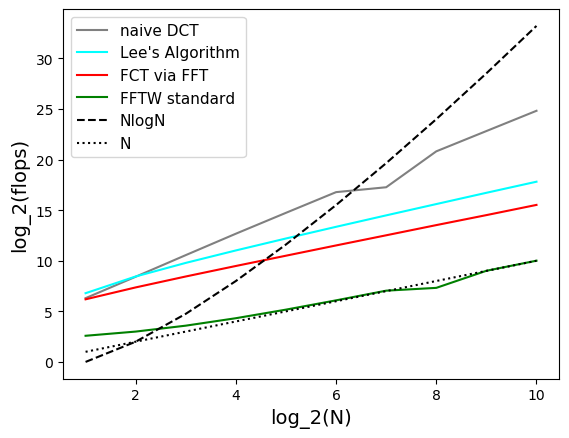

PyObject <matplotlib.legend.Legend object at 0x0000000048E51F28>

In [160]:
N = [2^i for i=1:10]
naive = [79, 343, 1510, 6550, 27400, 113000, 158000, 1850000, 7430000, 29800000]
fast = [111, 349, 886, 2080, 4720, 10500, 23000, 49900, 108000, 231000]
via = [73, 165, 349, 717, 1450, 2930, 5870, 11800, 23400, 47100]
fftw = [6, 8, 12, 20, 36, 68, 132, 160, 516, 1030]

plot(log2.(N), log2.(naive), label="naive DCT", color="gray")
plot(log2.(N), log2.(fast), label="Lee's Algorithm", color="cyan")
plot(log2.(N), log2.(via), label="FCT via FFT", color="red")
plot(log2.(N), log2.(fftw), label="FFTW standard", color="green")
# plot(log2.(N), [i^2 for i in log2.(N)], label="N^2", linestyle="dashdot", color="black")
plot(log2.(N), [i*log2(i) for i in log2.(N)], label="NlogN", linestyle="dashed", color="black")
plot(log2.(N), [i for i in log2.(N)], label="N", linestyle="dotted", color="black")
xlabel("log_2(N)", size=14)
ylabel("log_2(flops)", size=14)
legend(fontsize=11)


## Even Better
While the recursive FCT approach worked well compared to the naive approach, there are many other (sometimes better) methods. One main approach is taking the real-even part of a fast Fourier transform (FFT) because fast FFT algorithms are widely available while fast DCT algorithms are not. To improve upon this, we are able to eliminate many redundant steps from the FFT calculation when we are only interested in finding the DCT. 

Because the DCT is primarily used in compression algorithms, the input to the DCT is typically a small block ($8\times 8$ in JPEG) out of some larger input. In these cases, there are algorithms specifically designed to compute the DCT quickly and one prominent algorithm to do so is Feig's algorithm.